In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# TA-Lib for indicators
import talib

# PyNance and PyFolio will be used later, we just import them now
import talib                      # technical indicators
import pynance as py              # from GitHub version
import quantstats as qs   

# Make plots a bit nicer
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)


## Load or download a data (AAPL)

In [2]:
# ============================================
# Download GOOG daily data for a year
# ============================================

ticker = "GOOG"
start_date = "2009-01-01"
end_date   = "2023-12-29"

df = yf.download(ticker, start=start_date, end=end_date, progress=False) 
df.head()


C:\Users\Birhanu Matebe\AppData\Local\Temp\ipykernel_3320\1065922945.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2009-01-02,7.948609,7.960977,7.557264,7.633949,144961322
2009-01-05,8.115090,8.194004,7.792269,7.940693,196293007
2009-01-06,8.263762,8.430491,8.074026,8.237045,257971329
2009-01-07,7.965678,8.185839,7.885034,8.121770,180453860
2009-01-08,8.044341,8.044341,7.850153,7.873407,144567852


# 1. Data profiling

In [3]:
# ============================================
# Clean the columns (handle MultiIndex case)
# ============================================

# If columns are MultiIndex (like: ('Close', 'AMZN')), flatten them
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)  # keep only first level: Open, High, etc.

print("Cleaned columns:", df.columns.tolist())

# Optional: add a Ticker column (useful if using multiple tickers later)
df["Ticker"] = ticker

# Ensure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()




Cleaned columns: ['Close', 'High', 'Low', 'Open', 'Volume']


# - Summary Statistics 

In [4]:
# log the shape of dataset and the first five rows of dataset
print(f'the shape of GOOL dataset ${df.shape}')
df.head()

the shape of GOOL dataset $(3773, 6)


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2009-01-02,7.948609,7.960977,7.557264,7.633949,144961322,GOOG
2009-01-05,8.115090,8.194004,7.792269,7.940693,196293007,GOOG
2009-01-06,8.263762,8.430491,8.074026,8.237045,257971329,GOOG
2009-01-07,7.965678,8.185839,7.885034,8.121770,180453860,GOOG
2009-01-08,8.044341,8.044341,7.850153,7.873407,144567852,GOOG


In [5]:
# log the last examples of this dataset
df.tail()

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2023-12-21,140.836227,141.064660,139.518251,139.813229,18101500,GOOG
2023-12-22,141.749969,142.276366,141.089481,141.163983,18513500,GOOG
2023-12-26,141.849304,142.966658,141.531472,142.008205,11170100,GOOG
2023-12-27,140.478683,142.345911,140.092320,141.859236,17288400,GOOG
2023-12-28,140.319748,141.303025,139.870824,140.885881,12192500,GOOG


In [6]:
# log the last examples of this dataset
df.sample(5)

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2022-06-23,111.918617,112.427138,110.274367,112.182308,24710000,GOOG
2015-06-30,25.848610,26.133660,25.848114,26.122239,44344000,GOOG
2018-08-01,60.585896,61.254322,60.099228,60.982682,31344000,GOOG
2022-09-15,103.193825,105.488122,102.607831,104.296281,26494900,GOOG
2022-11-07,88.047462,88.335492,86.368947,86.746361,26899900,GOOG


In [7]:
# check more information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2009-01-02 to 2023-12-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3773 non-null   float64
 1   High    3773 non-null   float64
 2   Low     3773 non-null   float64
 3   Open    3773 non-null   float64
 4   Volume  3773 non-null   int64  
 5   Ticker  3773 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 206.3+ KB


In [8]:
# check if a null value exists
print("Check for missing values:")
df.isna().sum()

Check for missing values:


Price
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64

In [9]:
# 1. Calculate the percentage of missing values for every column
null_percentages = df.isnull().sum() / len(df) * 100

# 2. Filter the resulting Series for percentages greater than 5
columns_with_high_nulls = null_percentages[null_percentages > 5]

# 3. Print the results
print("Columns with >5% Null Values:")
print(columns_with_high_nulls)

Columns with >5% Null Values:
Series([], dtype: float64)


In [10]:
# Check if null rows exist
# 1. Define the critical columns
key_cols = ['Close', 'Open', 'High', 'Volume', 'Ticker']

# 2. Create a boolean mask:
missing_rows_mask = df[key_cols].isnull().any(axis=1)

# 3. Use the mask to display the subset of rows with missing data
missing_value_rows = df[missing_rows_mask]

# 4. Display the resulting DataFrame
print(f"Total rows with missing values in the key columns: {len(missing_value_rows)}")
print("Rows with Missing Data (only showing the key columns for focus):")
print(missing_value_rows[key_cols])

Total rows with missing values in the key columns: 0
Rows with Missing Data (only showing the key columns for focus):
Empty DataFrame
Columns: [Close, Open, High, Volume, Ticker]
Index: []


In [11]:
# log statistical data values
print("The description of the numeric columns:")
print(df.describe())

The description of the numeric columns:
Price        Close         High          Low         Open        Volume
count  3773.000000  3773.000000  3773.000000  3773.000000  3.773000e+03
mean     50.756332    51.261524    50.228839    50.729953  6.124324e+07
std      39.395902    39.832112    38.953446    39.368306  5.537615e+07
min       6.994489     7.408839     6.994489     7.133018  1.584340e+05
25%      16.847134    16.982198    16.697717    16.821404  2.575050e+07
50%      37.325077    37.646375    37.028109    37.386654  3.800606e+07
75%      69.185547    70.041696    68.306566    69.049477  8.271287e+07
max     149.684662   151.066223   148.868758   150.831319  5.952147e+08


In [12]:
#Overview of categorical columns
print("The description of the categorical columns:")
print(df.describe(include=['object']))

The description of the categorical columns:
Price  Ticker
count    3773
unique      1
top      GOOG
freq     3773


In [13]:
# log and check the frequency, and uniqueness of all dataset column
print("The description of all columns:")
print(df.describe(include='all'))


The description of all columns:
Price         Close         High          Low         Open        Volume  \
count   3773.000000  3773.000000  3773.000000  3773.000000  3.773000e+03   
unique          NaN          NaN          NaN          NaN           NaN   
top             NaN          NaN          NaN          NaN           NaN   
freq            NaN          NaN          NaN          NaN           NaN   
mean      50.756332    51.261524    50.228839    50.729953  6.124324e+07   
std       39.395902    39.832112    38.953446    39.368306  5.537615e+07   
min        6.994489     7.408839     6.994489     7.133018  1.584340e+05   
25%       16.847134    16.982198    16.697717    16.821404  2.575050e+07   
50%       37.325077    37.646375    37.028109    37.386654  3.800606e+07   
75%       69.185547    70.041696    68.306566    69.049477  8.271287e+07   
max      149.684662   151.066223   148.868758   150.831319  5.952147e+08   

Price  Ticker  
count    3773  
unique      1  
top    

In [14]:
#check if duplication of rows exist
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


In [15]:
# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)

Cardinality (categoricals): {'Ticker': 1}


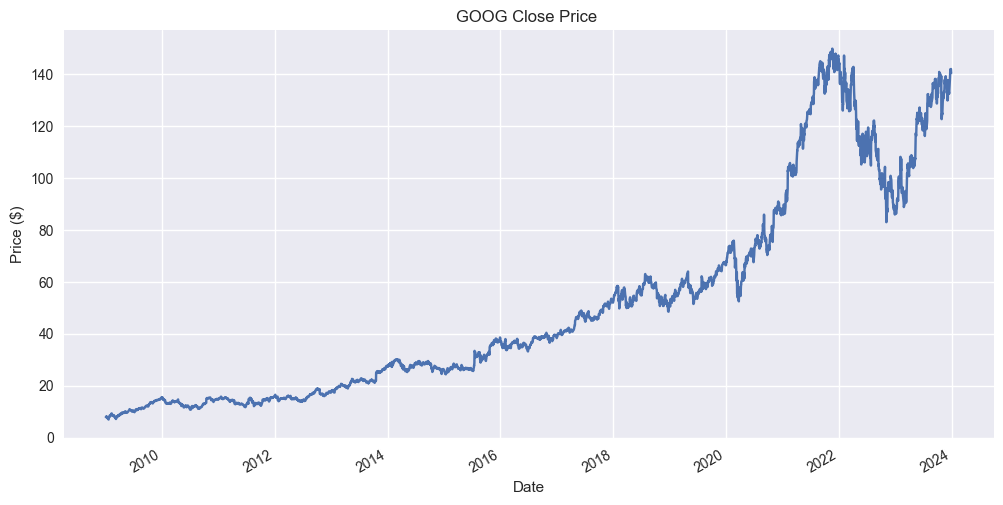

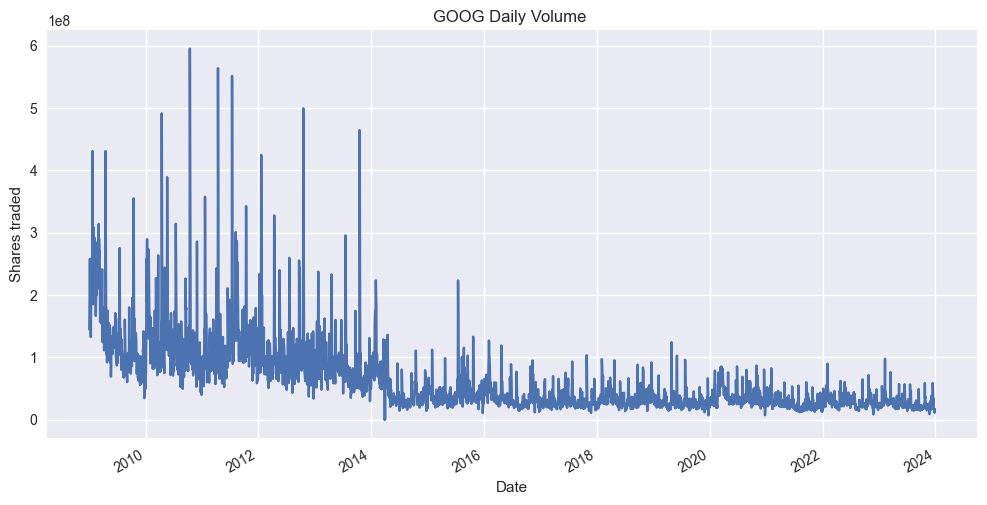

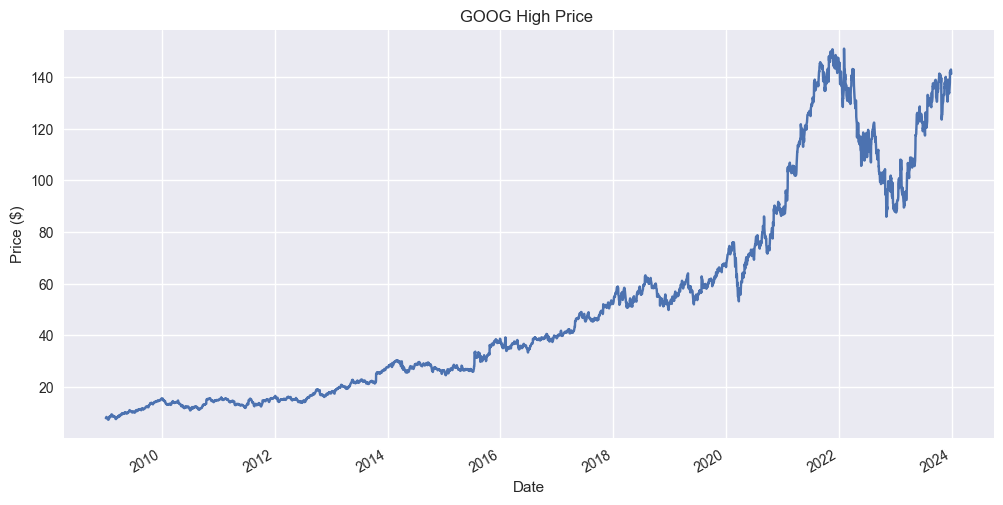

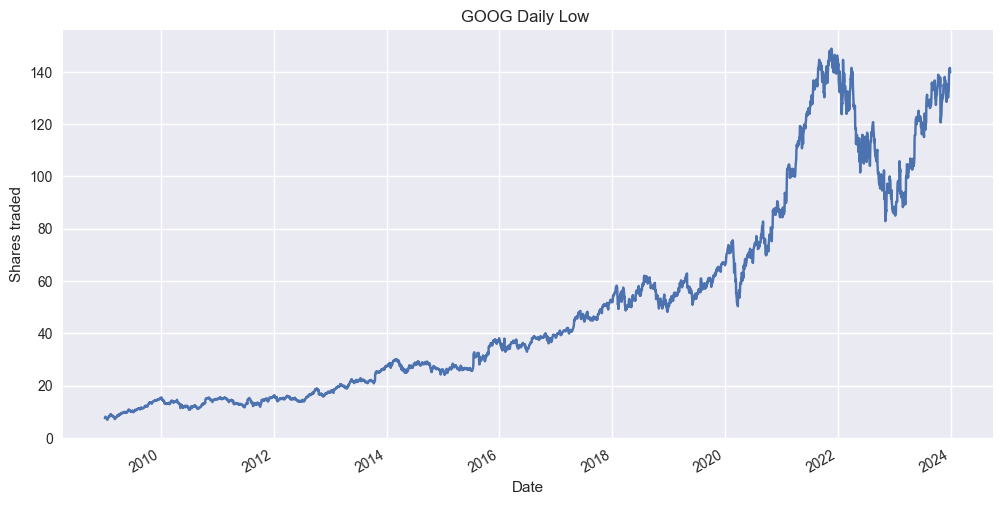

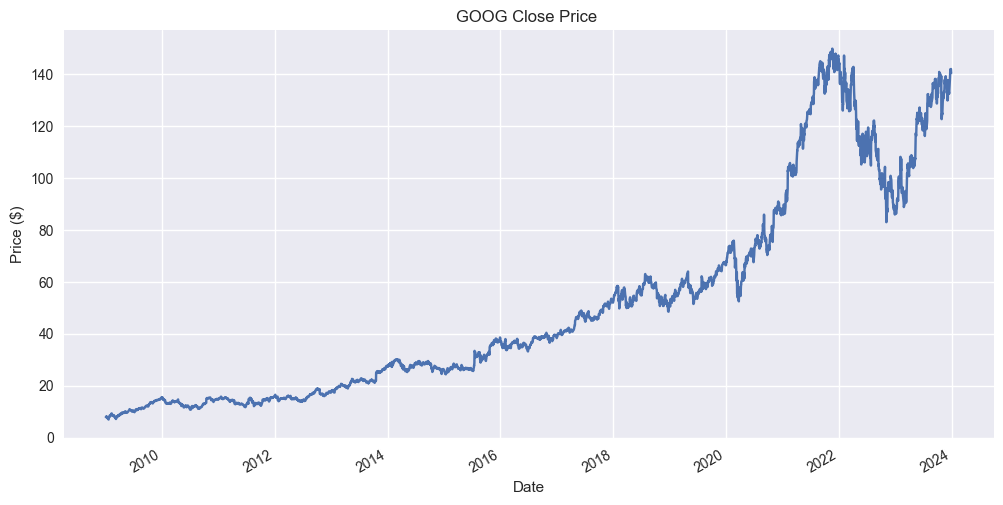

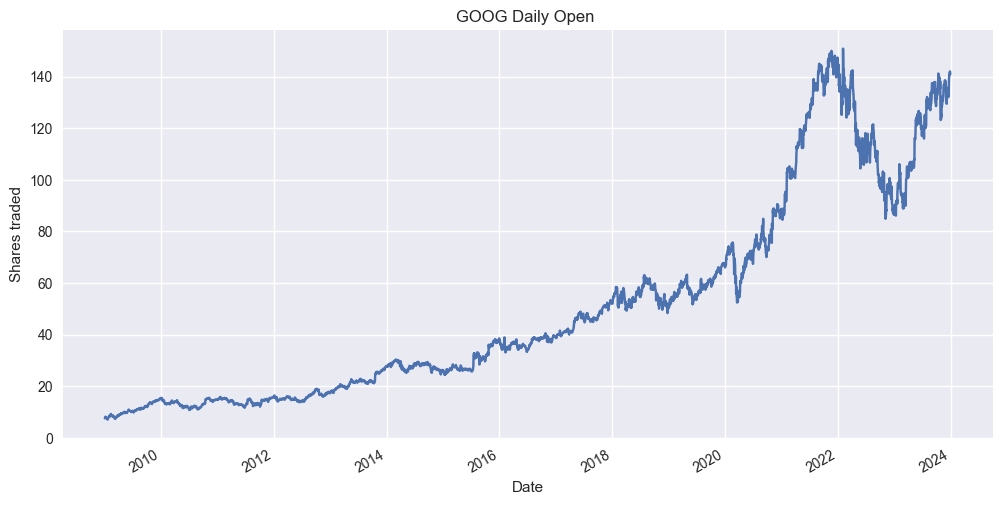

In [16]:
# ============================================
# Quick look at price and volume
# ============================================

# Close price chart
df["Close"].plot(title="GOOG Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Volume"].plot(title="GOOG Daily Volume ")
plt.ylabel("Shares traded")
plt.show()
df["High"].plot(title="GOOG High Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Low"].plot(title="GOOG Daily Low ")
plt.ylabel("Shares traded")
plt.show()
df["Close"].plot(title="GOOG Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Open"].plot(title="GOOG Daily Open ")
plt.ylabel("Shares traded")
plt.show()


## Stock price over time

## Interpretation of Alphabet (GOOG) Close Price History (2009–2024)
1. Long-Term Trend: Decades of Aggressive Growth
- The primary feature is the extraordinary, non-linear growth of the closing price, which rose from under $10 to a peak near $150 (split-adjusted). This performance is underpinned by the dominance of its search advertising business and the exponential expansion of its cloud services.

2. Key Phases of Price Movement
- 2009 – 2021: Smooth, Accelerated Uptrend: For over a decade, the price maintained a clean, powerful uptrend. The growth rate accelerated in the later years, culminating in a significant surge during and after the pandemic, where the price peaked around late 2021.

- Late 2021 – Late 2022: The Bear Market Correction: Like Amazon, Alphabet experienced a major technical breakdown and bear market correction. The stock price fell sharply from its high near $150 to a low around $83 (a decline of about 44-45%).

- Drivers of the Drop: This correction was driven by a combination of factors, including the inflation-led downturn, rising interest rates, heightened regulatory scrutiny (particularly regarding antitrust issues), and investor concerns over the potential disruption of its core search business by AI.

- 2023 – Early 2024: The Recovery and Return to Highs: Following the deep drawdown, the price began a strong recovery in 2023, driven by a sharp rise in its Price-to-Sales (P/S) ratio, margin expansion supported by growing profitability of Google Cloud, and renewed confidence in its strategic AI initiatives. The stock eventually rallied back to challenge its previous all-time highs.

3. Volatility Profile
- The chart indicates that Alphabet's stock is a high-growth asset that delivered massive long-term returns, but it is vulnerable to significant macroeconomic and regulatory shocks. While its long-term growth is undeniable, the severity of the 2022 correction shows that periods of deep selling pressure are a risk for this security, similar to AMZN and unlike the resilient nature of AAPL's price action during the same period.

In [17]:
# ============================================
# Compute technical indicators with TA-Lib
# ============================================

# Use 'Adj Close' if available, otherwise 'Close'
if "Adj Close" in df.columns:
    price = df["Adj Close"]
else:
    price = df["Close"]

# --- Moving Averages ---
df["SMA_20"] = talib.SMA(price, timeperiod=20)
df["SMA_50"] = talib.SMA(price, timeperiod=50)
df["EMA_20"] = talib.EMA(price, timeperiod=20)

# --- RSI ---
df["RSI_14"] = talib.RSI(price, timeperiod=14)

# --- MACD ---
df["MACD"], df["MACD_signal"], df["MACD_hist"] = talib.MACD(
    price, fastperiod=12, slowperiod=26, signalperiod=9
)


df.tail()


Price,Close,High,Low,Open,Volume,Ticker,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_signal,MACD_hist
Date,,,,,,,,,,,,,
2023-12-21,140.836227,141.064660,139.518251,139.813229,18101500,GOOG,134.786124,133.866515,135.234005,63.499982,1.025635,0.362053,0.663582
2023-12-22,141.749969,142.276366,141.089481,141.163983,18513500,GOOG,135.009595,133.914785,135.854573,64.953269,1.412013,0.572045,0.839968
2023-12-26,141.849304,142.966658,141.531472,142.008205,11170100,GOOG,135.246474,133.999009,136.425500,65.115880,1.706563,0.798949,0.907614
2023-12-27,140.478683,142.345911,140.092320,141.859236,17288400,GOOG,135.386517,134.017880,136.811517,60.916034,1.808551,1.000869,0.807682
2023-12-28,140.319748,141.303025,139.870824,140.885881,12192500,GOOG,135.628858,134.023641,137.145634,60.429311,1.855167,1.171729,0.683438


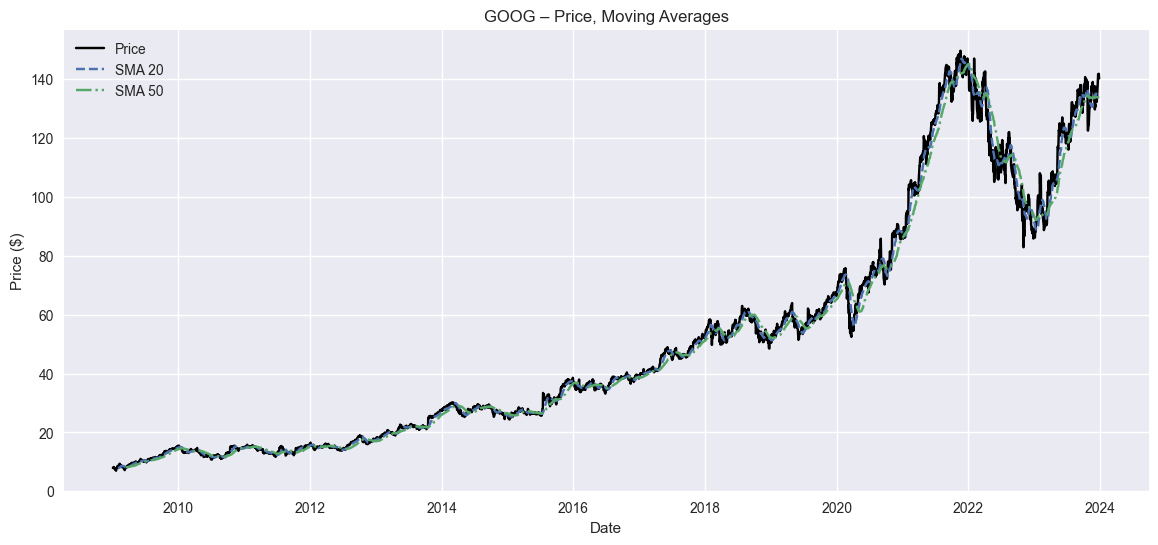

In [18]:
# ============================================
# Price + SMA + Bollinger Bands
# ============================================

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, price, label="Price", color="black")
ax.plot(df.index, df["SMA_20"], label="SMA 20", linestyle="--")
ax.plot(df.index, df["SMA_50"], label="SMA 50", linestyle="-.")


ax.set_title("GOOG – Price, Moving Averages")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.legend()
plt.show()


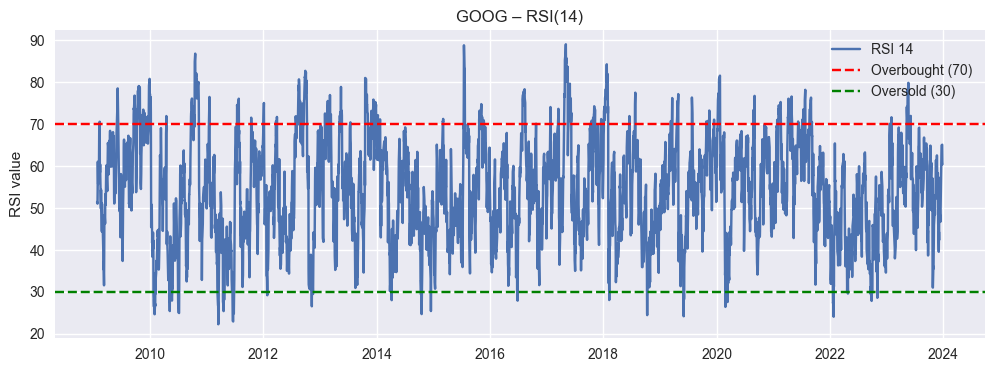

In [19]:
# ============================================
# RSI – Overbought / Oversold
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["RSI_14"], label="RSI 14")
ax.axhline(70, color="red", linestyle="--", label="Overbought (70)")
ax.axhline(30, color="green", linestyle="--", label="Oversold (30)")

ax.set_title("GOOG – RSI(14)")
ax.set_ylabel("RSI value")
ax.legend()
plt.show()


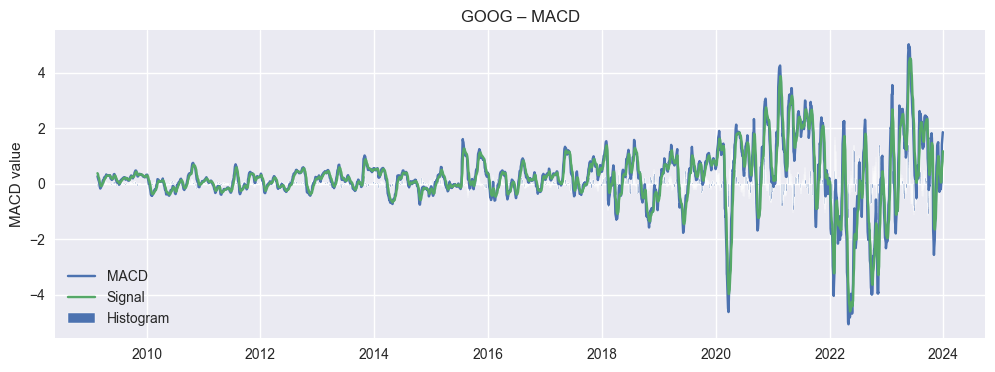

In [20]:
# ============================================
# MACD – Trend & momentum
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["MACD"], label="MACD")
ax.plot(df.index, df["MACD_signal"], label="Signal")
ax.bar(df.index, df["MACD_hist"], label="Histogram")

ax.set_title("GOOG – MACD")
ax.set_ylabel("MACD value")
ax.legend()
plt.show()


## Interpretation of Alphabet (GOOG) Price and Moving Averages (2009–2024)
1. The Long-Term Bull Trend (2009–2021)
- Confirmation of Uptrend: For over a decade, the Close Price (black line) remained comfortably above both the SMA 20 (dashed blue) and SMA 50 (dotted green). Furthermore, the SMA 20 was consistently above the SMA 50. This alignment is the classic signature of a strong, dominant bull market.

- Dynamic Support: During minor and moderate pullbacks, the moving averages effectively acted as dynamic support, catching the falling price and helping it rebound (e.g., throughout 2017-2019 and 2020-2021).

2. The Defining 2022 Correction and Breakdown 
- This period clearly shows the technical breakdown that occurred, similar to Amazon but contrasting with Apple's performance:

- Price Crashes Below Averages: In late 2021/early 2022, the price decisively crashed below both the SMA 20 and SMA 50.

- The Death Cross: Critically, the SMA 20 crossed sharply and decisively below the SMA 50. This crossover, a technical "Death Cross," signaled the end of the short-to-medium-term bullish trend and confirmed the start of a deep, sustained correction (bear market).

- Averages as Resistance: During this decline, the moving averages flipped roles and acted as resistance. When the price attempted to rally (move upward from the lows), it would frequently stall or reverse upon hitting the underside of the SMA 20 or SMA 50, confirming the market's bearish consensus.

3. The 2023 Recovery and Trend Reversal 
- The Golden Cross: The strong recovery in 2023 saw the price rapidly move back above both averages. This was followed by the SMA 20 crossing back above the SMA 50 (a "Golden Cross" using these averages). This signaled the definitive return to a bullish trend for the short and medium term.

- Current Status: By early 2024, the price is trading well above both averages, which are once again pointing upward, confirming the technical indicators have fully re-established a strong uptrend.

## Interpretation of Alphabet (GOOG) Relative Strength Index (RSI 14)
- The RSI (14) measures the speed and change of GOOG's closing price movements. The pattern for GOOG's RSI is very similar to that of AMZN, confirming that both stocks faced similar intense momentum challenges during the 2022 market downturn.

1. High Volatility and Momentum Peaks
- Frequent Overbought (RSI > 70): The RSI line repeatedly crosses the 70 (Overbought) threshold. This is typical for a strong, long-term growth stock and signifies periods of intense buying interest and rapidly accelerating momentum.

- Neutral Zone (40-70): When the stock pulls back, the RSI usually finds support in the 40-50 range, indicating that the selling pressure is typically absorbed before reaching a critical low.

2. Critical: The 2022 Momentum Breakdown 
Deep Oversold Territory (RSI < 30): The most crucial feature is the clear break below the 30 (Oversold) line in 2022.

- Significance: Unlike Apple, which generally avoided this, GOOG's dip below 30 confirms the severity of the 2022 bear market correction. It signals that the selling pressure was aggressive and prolonged, fueled by genuine investor fear regarding the company's outlook (macroeconomic fears, regulatory risk, and AI disruption).

- High-Conviction Buying: Historically, these sustained dips into Oversold territory have marked periods where the stock was technically undervalued by momentum standards, leading to a strong reversal and recovery.

3. The 2023 Momentum Restoration
The strong recovery in the closing price in 2023 is mirrored by the RSI sharply climbing back toward the 70 line. This demonstrates a powerful restoration of bullish momentum, confirming that investor consensus has returned to a positive long-term outlook for Alphabet.

## Interpretation of Alphabet (GOOG) MACD
- The MACD (12, 26, 9) measures the relationship between two Exponential Moving Averages (EMAs) to identify changes in the strength, direction, and momentum of the closing price.

1. The Long-Term Trend via the Zero Line
- Bullish Period (2009–2021): For the majority of this rally, the MACD Line and Signal Line are consistently positioned above the Zero Line. This confirms that the short-term momentum of the closing price was reliably faster than the medium-term momentum, indicating a strong, established uptrend.

- The 2022 Downtrend: This period shows the MACD plunging dramatically and remaining in negative territory for much of 2022.

- Significance: This deep, sustained dip below zero (reaching values near -5) confirms the severe, prolonged loss of momentum and the technical bear market GOOG experienced. The selling was intense, and positive momentum was entirely absent.

2. Crossover Signals: Volatility and Entry Points
The crossovers between the MACD Line and the Signal Line are key:

- Buy Signals (MACD crosses ABOVE Signal Line): These crossovers initiated new, strong phases of bullish momentum (e.g., the decisive crossover in early 2023 that preceded the strong recovery).

- Sell Signals (MACD crosses BELOW Signal Line): These signals coincided with the start of major pullbacks and the decisive start of the 2022 bear market, providing timely warnings of decelerating momentum.

3. The 2023 Recovery
As the price recovered, the MACD Line sharply crossed back above the Zero Line and is trading consistently in positive territory. This confirms that positive momentum has been decisively restored, signaling a return to the long-term uptrend (as of early 2024).